TO DO:

Look into PyViz for graph relaxation

Look into points of interest or "places" on google or osm

Play around with interpolation

In [1]:
import requests
import json
import numpy as np
import math
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import tilemapbase
import matplotlib.image as img
from PIL import Image
import itertools
from scipy.ndimage import geometric_transform
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
# Don't need if you have run before; DB file will already exist.
tilemapbase.init(create=True)

In [2]:
import random

random.seed(10)

In [3]:
with open('apikey.txt') as f:
    api_key = f.readline()
    f.close

In [17]:
url = "https://maps.googleapis.com/maps/api/staticmap?"
center = "39.9524,-75.1635"
#salt lake
# lng = -111.9693297
# lat = 40.629771
# zoom = 13

# Portland
lng = -122.6715821
lat = 45.5188353
zoom = 14

res = 9
picHeight = 640 #Resulting image height in pixels (x2 if scale parameter is set to 2)
picWidth = 640

r = requests.get(url + "center=" + str(lat) + ',' + str(lng) + "&zoom=" +
                   str(zoom) + "&size=" + str(picHeight) + "x" + str(picWidth) + "&key=" +
                             api_key)

f = open('static_map.png', 'wb')
f.write(r.content)
f.close()

(640, 640, 3)


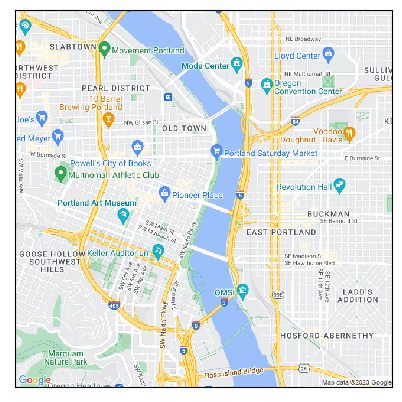

In [18]:
# reading png image file
im = img.imread('static_map.png')
print(im.shape)

# show image
fig, ax = plt.subplots(figsize=(5,5), dpi=100)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.imshow(im)

In [19]:
def lng_lat_to_mercator(lng, lat,mapWidth=1, mapHeight=1):
    #Converts longitude,latitude to mercator coordinates
    x = (lng + 180) * (mapWidth/360)
    y = ((1 - math.log(math.tan(lat * math.pi / 180) + 1 / math.cos(lat * math.pi / 180)) / math.pi) / 2) * mapHeight

    return(x, y)

def mercator_to_lng_lat(x, y,mapWidth=1, mapHeight=1):
    #Converts mercator coordinates to (longitude,latitude)
    lng = x / mapWidth * 360 - 180

    n = math.pi - 2 * math.pi * y / mapHeight
    lat = (180 / math.pi * math. atan(0.5 * (math.exp(n) - math.exp(-n))))

    return(lng, lat)

def get_image_bounds(picWidth, picHeight, zoom, lng, lat):
    #Finds the lng,lat coordinates for the SW and NE points given the center
    
    mapHeight = 256 #Original map size - specific to Google Maps
    mapWidth = 256
    
    xScale = math.pow(2, zoom) / (picWidth/mapWidth)
    yScale = math.pow(2, zoom) / (picHeight/mapWidth)
    
    centreX, centreY = lng_lat_to_mercator(lng, lat, mapWidth, mapHeight)

    southWestX = centreX - (mapWidth/2)/ xScale
    southWestY = centreY + (mapHeight/2)/ yScale
    SWlng, SWlat = mercator_to_lng_lat(southWestX, southWestY, mapWidth, mapHeight)

    northEastX = centreX + (mapWidth/2)/ xScale
    northEastY = centreY - (mapHeight/2)/ yScale
    NElng, NElat = mercator_to_lng_lat(northEastX, northEastY, mapWidth, mapHeight)

    return[[SWlng, SWlat], [NElng, NElat]]

def make_lng_lat_grid(SWcorner, NEcorner, res):
    return([[i,j] 
            for i in np.linspace(SWcorner[0], NEcorner[0], 9) 
            for j in np.linspace(SWcorner[1], NEcorner[1], 9)])

def grid_to_mercator(grid):
    new_grid = [lng_lat_to_mercator(grid[i][0],grid[i][1]) for i in range(len(grid))]
    return(new_grid)

def snap_grid(grid):
    #Warning: this can take a while if you have a lot of grid points since it is calling the OSRM 
    # with many requests.
    new_grid = []
    url = 'http://router.project-osrm.org/nearest/v1/driving/'
    for i in range(len(grid)):
        snapped_cord = requests.get(url + str(grid[i][0]) + ',' + str(grid[i][1]) + '?number=1')
        if snapped_cord.json()['code'] != 'Ok':
            print('Something went wrong with coordinate '+str(i))
        new_grid.append(snapped_cord.json()['waypoints'][0]['location'])
        
    return(new_grid)

def lng_lat_to_pixel(lng,lat,zoom,centerLng,centerLat,picWidth,picHeight,mapWidth=256,mapHeight=256):
    #convert to mercator units
    centerX, centerY = lng_lat_to_mercator(centerLng, centerLat,mapWidth, mapHeight)
    x,y = lng_lat_to_mercator(lng, lat, mapWidth, mapHeight)
    
    xPixel = (x-centerX)*math.pow(2, zoom)+picWidth/2
    yPixel = (y-centerY)*math.pow(2, zoom)+picHeight/2
    
    return (xPixel,yPixel)

def lng_lat_grid_to_pixel_grid(grid,zoom,centerLng,centerLat,picWidth,picHeight,mapWidth=256,mapHeight=256):
    new_grid = [lng_lat_to_pixel(grid[i][0],grid[i][1],zoom,centerLng,centerLat,picWidth,picHeight,mapWidth,mapHeight) 
                      for i in range(len(grid))]
    return new_grid

In [20]:
%%time
corners = get_image_bounds(picWidth, picHeight, zoom, lng, lat)
lng_lat_grid = make_lng_lat_grid(corners[0], corners[1],res)
snapped_lng_lat_grid = snap_grid(lng_lat_grid)

CPU times: user 379 ms, sys: 24.4 ms, total: 404 ms
Wall time: 45.5 s


In [21]:
pixel_grid = lng_lat_grid_to_pixel_grid(lng_lat_grid,zoom, lng, lat, picWidth, picHeight)
snapped_pixel_grid = lng_lat_grid_to_pixel_grid(snapped_lng_lat_grid, zoom, lng, lat, picWidth, picHeight)

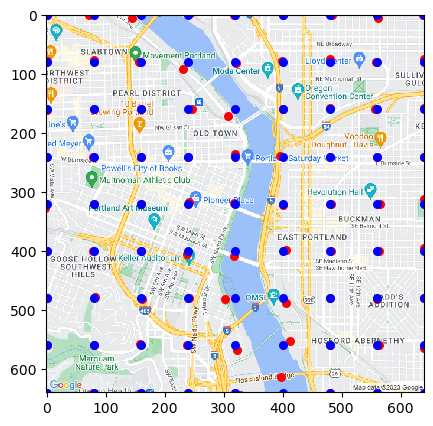

In [22]:
pixelGrid = [[i,j] for i in np.linspace(0,picWidth,res) for j in np.linspace(0,picHeight,res)]

fig, ax = plt.subplots(figsize=(5,5), dpi=100)
#ax.xaxis.set_visible(False)
#ax.yaxis.set_visible(False)
ax.scatter(*zip(*snapped_pixel_grid), marker='o', s=30,c='red')
ax.scatter(*zip(*pixel_grid), marker='o', s=30,c='blue')

plt.imshow(im)

fig.savefig("test.png",bbox_inches='tight')

In [23]:
def osrm_table_request(loc_mat):
    locations = ';'.join([','.join(map(str, x)) for x in loc_mat])
    text = f"http://router.project-osrm.org/table/v1/driving/{locations}"
    response = requests.get(text)
    return(response)

In [24]:
response = osrm_table_request(snapped_lng_lat_grid)
X = response.json()['durations']
X = np.asarray(X)
driving_time_matrix = (X+X.T)/2

In [25]:
embedding = MDS(n_components=2, dissimilarity='precomputed')
transformed_grid = embedding.fit_transform(driving_time_matrix)

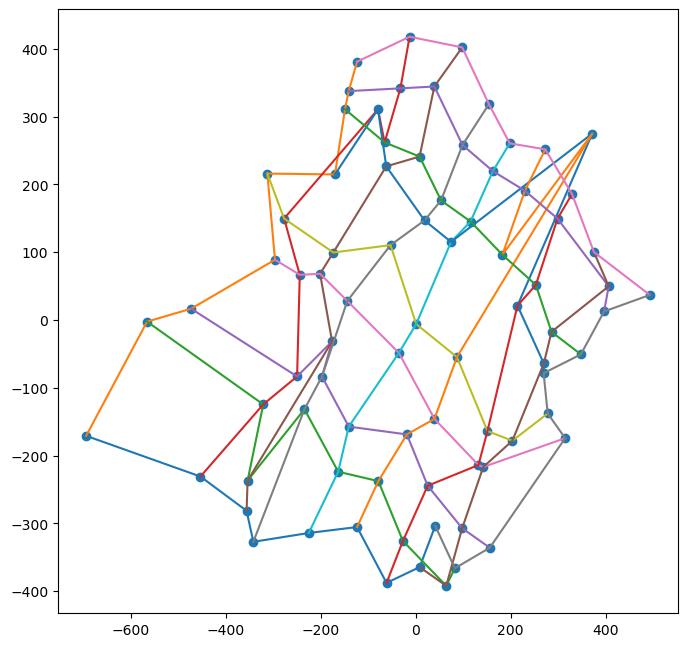

In [26]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
plt.scatter(transformed_grid[:,0], transformed_grid[:,1])
for i in range(res):
    plt.plot(transformed_grid[9*i:9*(i+1),0], transformed_grid[9*i:9*(i+1),1])
    plt.plot(transformed_grid[i::9,0], transformed_grid[i::9,1])

In [29]:
%%time
#THIS IS NOT WORKING CORRECTLY, LEARN ABOUT HOW TO TRANSFORM AND DO INTERPOLATION

vals = np.concatenate((transformed_grid[:,0], transformed_grid[:,1]))
output_grid = (transformed_grid-min(vals))*640/(max(vals)-min(vals))

snapped_pixel_grid = np.asarray(snapped_pixel_grid)
x_interp = LinearNDInterpolator(snapped_pixel_grid, output_grid[:,0])
y_interp = LinearNDInterpolator(snapped_pixel_grid, output_grid[:,1])

# x_interp = CloughTocher2DInterpolator(snapped_pixel_grid, output_grid[:,0])
# y_interp = CloughTocher2DInterpolator(snapped_pixel_grid, output_grid[:,1])

def map_transform(output_coords):
    return (x_interp(output_coords[0],output_coords[1]),
            y_interp(output_coords[0],output_coords[1]), 
            output_coords[2]) # this preserves the color of the pixel

transformed_img = geometric_transform(im, map_transform)

CPU times: user 43.2 s, sys: 179 ms, total: 43.4 s
Wall time: 43.6 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


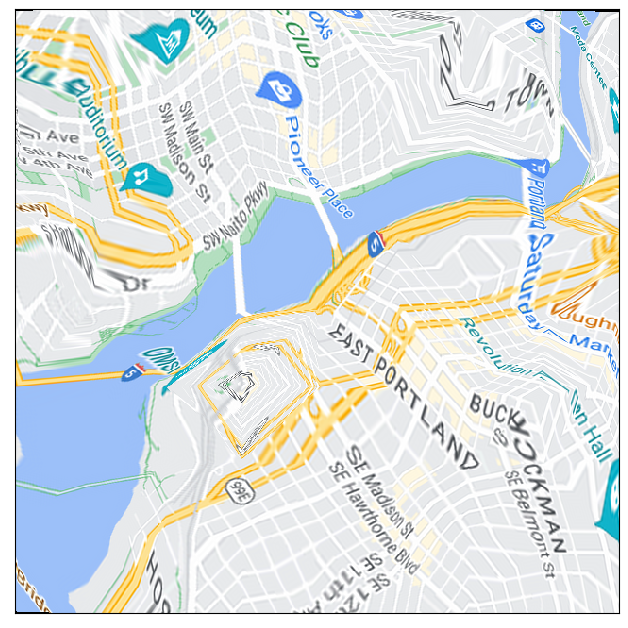

In [30]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.imshow(transformed_img)

fig.savefig("transformed.png",bbox_inches='tight')

# TILE MAP BASE STUFF

In [23]:
%%time
lng = -75.1635
lat = 39.9524
loc = (-75.1635,39.9524)
deg_range = 0.05
res = 9
SWcorner = [lng-deg_range,lat-deg_range]
NEcorner = [lng+deg_range,lat+deg_range]

lng_lat_grid = make_lng_lat_grid(SWcorner, NEcorner,res)
snapped_lng_lat_grid = snap_grid(lng_lat_grid)

CPU times: user 368 ms, sys: 36.1 ms, total: 404 ms
Wall time: 1min 7s


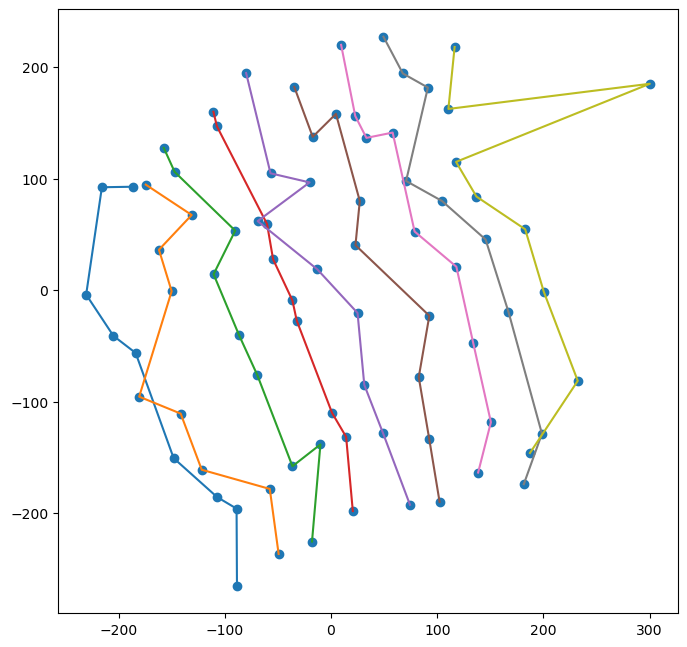

In [24]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
plt.scatter(transformed_grid[:,0], transformed_grid[:,1])

for i in range(res):
    plt.plot(transformed_grid[9*i:9*(i+1),0], transformed_grid[9*i:9*(i+1),1])

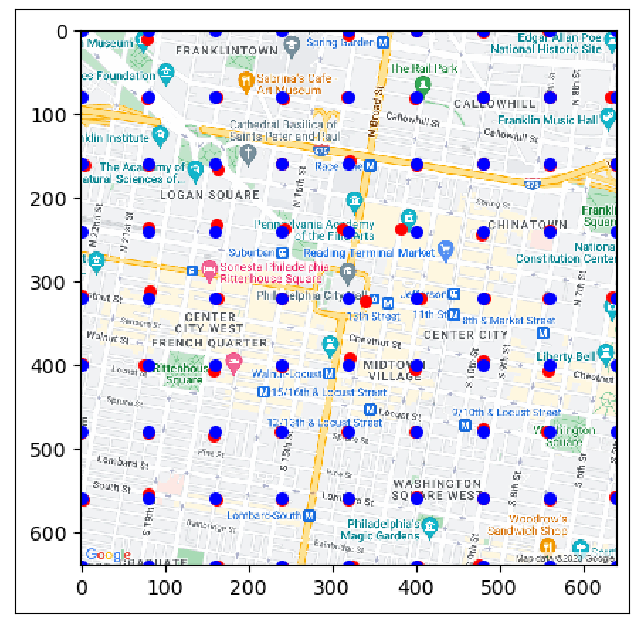

In [25]:
img=plt.imread('test.png')
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.imshow(img)

In [26]:
merc_grid = grid_to_mercator(lng_lat_grid)
snapped_merc_grid = grid_to_mercator(snapped_lng_lat_grid)

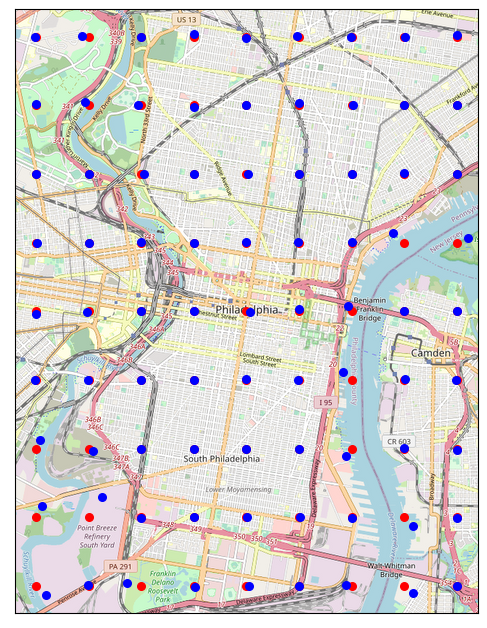

In [27]:
extent = tilemapbase.Extent.from_lonlat(lng-(deg_range)*(1.1), lng + (deg_range)*(1.1),
                                        lat - (deg_range)*(1.1), lat + (deg_range)*(1.1))
#extent = extent.to_aspect(1.0)

fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=600)
plotter.plot(ax, tilemapbase.tiles.build_OSM())

ax.scatter(*zip(*merc_grid), marker='o', s=30, c='red')
ax.scatter(*zip(*snapped_merc_grid), marker='o', s=30, c='blue')
#ax.scatter(*zip(*merc_grid), marker='o', s=30, c=range(res*res), cmap="magma")

fig.savefig("test.png",bbox_inches='tight',pad_inches=0.0)
